# CLUB algorithm draft - Online Clustering of Bandits

In [1]:
import numpy as np
import numpy.random as npr
import numpy.linalg
import pandas as pd
from scipy.spatial.distance import euclidean
import networkx as nx
import matplotlib.pyplot as plt

### Commentaires

Quelques remarques pour la partie Artificial Datasets page 6:
   
* Vecteurs des vrais clusters $u_{j}$ est crée directement. Pas besoin de M et b
* Matrices C générées sur la sphere unitaire, on aurait alors un nombre infini de profils de users mais pas trop distants les uns des autres (je l'ai déjà intégré dans le code avec la fonction sphere_unif)
* T = 5000 + 50,000 pourquoi cette décomposition ?

Problème de convergence: sur une période suffisamment longue, on supprime tous les noeuds du graphe <br>

# Initialisation

In [36]:
#tests
V=nx.Graph()
V.add_node(1)
V.add_node(2)
V.add_node(3)
V.add_edge(1,2)
V.add_edge(3,2)
print(V.adj)

{1: {2: {}}, 2: {1: {}, 3: {}}, 3: {2: {}}}


In [52]:
V=nx.Graph(np.ones([4,4]))
#V=nx.Graph(np.identity(3))
#print(V.adj)
print(V[1])

{0: {'weight': 1.0}, 1: {'weight': 1.0}, 2: {'weight': 1.0}, 3: {'weight': 1.0}}


In [166]:
V.remove_edge(0,1)
V.remove_edge(2,3)
V.remove_edge(3,1)
V.remove_edge(0,2)

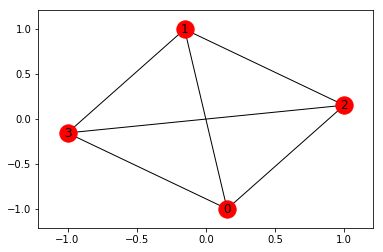

In [170]:
nx.draw_networkx(V)
plt.show()

In [4]:
#sphere unitaire pour générer les matrices de contexte C à chaque période
def sphere_unif(dim,N):
    norm = np.random.normal
    normal_deviates = norm(size=(dim, N))
    radius = np.sqrt((normal_deviates**2).sum(axis=0))
    points = normal_deviates/radius
    return(points)

In [187]:
#itérations
T=2000
#nombre d'utilisateurs
n_user=27
#dimension des catégories/labels à prédire
D=3
#matrice M_i associée à l'approximation des paramètres du cluster j(i)
#paramètre b_i associé à l'approximation des paramètres du cluster j(i)
d_M=dict()
d_b=dict()
for i in range(n_user):
    d_M['M%d' % i]=np.identity(D)
    d_b['b%d' % i]=np.zeros(D)

#vrai nombre de clusters (supposé connu et constant pour chaque période) 
c=10    
#variation autour de la payoff (white noise)
sigma=1
#nombre de users dans chaque cluster

#matrice U des vrais u_j
U=sphere_unif(c,D)

#initialiser omega
omega=np.ones(D)
#init matrice V du graphe réel
#V=nx.Graph( np.ones([n_user,n_user]) )
V = nx.dense_gnm_random_graph(n_user,int(n_user*np.log(n_user)))

#nombre de clusters estimé (initialisé selon le graph initial)
m=len( list( nx.connected_component_subgraphs(V) ) )  

#paramètre du confidence bound
alpha=1
alpha2=12
#standard deviation du white noise
sigma=1
#liste des indices précédents
list_i=[]
#liste de matrices de contexte C_it pré-définies. Pour user i à période t, on va piocher dans cette liste
#nb_context=int(n_user/3) #nombre de contextes différents
list_C=[]
for cont in range(T):
    #list_C.append(npr.uniform(0,1,size=[D,c]))
    #list_C.append(npr.normal(0,1,size=[D,c]))
    list_C.append(sphere_unif(D,c))

# nombre de clusters en fonction de la période
list_m=[]

In [188]:
list_CB=np.zeros(T)
list_omega=np.zeros(T)
list_payoff=[]

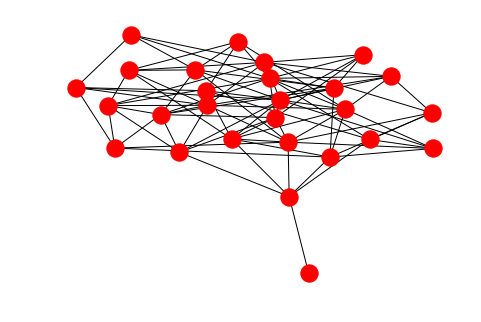

In [87]:
nx.draw(V)
plt.show()

## Algo CLUB

In [189]:
%%capture
for t in range(T):
    print("période t=",t)
    #choisir aléatoirement un user i
    i=int(npr.uniform(0,n_user))
    print("user i=",i)
    list_i.append(i)
    #reçoit contexte C_it généré aléatoirement sur une sphere unitaire
    #C = sphere_unif(D,c)
    #piocher dans un ensemble de profils générés aléatoirement sur t=1...T
    #indique les préférences de user i à période t pour chaque cluster estimé 1...c
    C = list_C[ int( npr.uniform(0,T) ) ]  
    #genère omega
    omega=np.zeros([n_user,D])
    omega[i,:]=np.dot(np.linalg.inv(d_M['M'+str(int(i))]),d_b['b'+str(int(i))])
    #détermine l'indice du cluster de i: j_t(i)
    #calcule M_bar et b_bar et omega aggrégés
    #on récupère tous les indices qui appartiennent au même cluster que celui de i
    M_index = [ n for n in V[i] ]  #liste d'indices des noeuds au point i
    if M_index==[]:   #si le noeud i est tout seul
        M_index=np.array([i])
    M_sum=sum([d_M['M'+str(int(k))] for k in M_index])
    M_bar=np.identity(D)+M_sum-len(M_index)*np.identity(D)
    b_bar=sum([d_b['b'+str(int(k))] for k in M_index])
    #print("M_index",M_index)
    #print("M_bar",M_bar)
    #print("b_bar",b_bar)
    omega_bar=np.dot(np.linalg.inv(M_bar),b_bar)
    #détermine k_t optimal pour cluster j_t(i)
    #print("omega_bar:",omega_bar)
    vect_k=np.zeros(c)
    for k in range(c):
        CB=alpha*np.sqrt(np.dot(np.dot(C[:,k].T,np.linalg.inv(M_bar)),C[:,k])*np.log(t+1))
        vect_k[k]=CB+np.dot(omega_bar.T,C[:,k])
    k_t=[v for v in range(c) if vect_k[v]==np.max(vect_k)][0]
    #calcule payoffs avec u_j
    a_t=np.dot(U[k_t],C[:,k_t])+npr.normal(loc=0,scale=sigma,size=1)
    list_payoff.append(a_t)
    #update weights
    d_M['M'+str(int(i))]=d_M['M'+str(int(i))]+np.dot(C[:,k_t],C[:,k_t].T)
    d_b['b'+str(int(i))]=d_b['b'+str(int(i))]+a_t*C[:,k_t]
    #update clusters
    T_i=list_i.count(i)-1  #nombre de user i piochés sur les périodes précédentes (exclue période t actuelle)
    #if list_i.count(i)==1: #cas spécifique pour lorsque i est pioché pour la 1ère fois
    #    T_i=1
    CB_tild=np.zeros(n_user) #calcul des bornes de confiance pour tous les user
    CB_tild[i]=alpha2*np.sqrt((1+np.log(1+T_i))/(1+T_i)) #CB pour i, on en a besoin dans la boucle sur les autres users
    nodes_i=[k for k in V[i]]
    print("voisins de i",nodes_i)
    for l in nodes_i:#np.delete(nodes_i,i): #CB pour les autres users voisins de i
        T_i=list_i.count(l)-1
    #    if list_i.count(l)==1:
    #        T_i=1
        if list_i.count(l)==0:
            T_i=0
        CB_tild[l]=alpha2*np.sqrt((1+np.log(1+T_i))/(1+T_i))
        omega[l,:]=np.dot(np.linalg.inv(d_M['M'+str(int(l))]),d_b['b'+str(int(l))])
        norm_diff_omega=euclidean(omega[l,:],omega[i,:])
        print( "Confidence bounds: \n" , CB_tild[l] + CB_tild[i] )
        print("omega norm: \n", norm_diff_omega)
        list_CB[t]=list_CB[t]+CB_tild[l]
        list_omega[t]=list_omega[t]+(norm_diff_omega)
        if (norm_diff_omega > CB_tild[l] + CB_tild[i]): #si la distance entre users i et l on brise le lien
            V.remove_edge(i,l)
            print("brise le lien entre users",i,"et",l)
    #update le nombre de sous-graphes i.e. nombre de clusters at la période t
    m=len( list( nx.connected_component_subgraphs(V) ) )
    print("nombre de clusters:",m)
    list_m.append(m)
    #nx.draw_networkx(V)
    #plt.show()

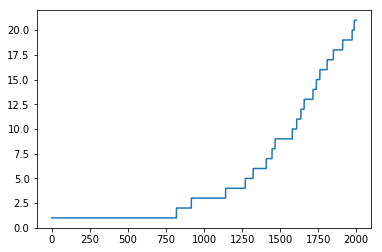

In [190]:
plt.plot(list_m)
plt.show()

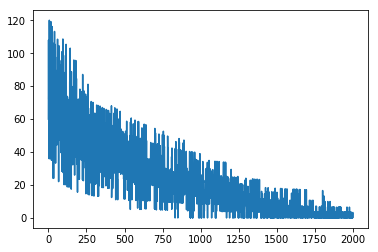

In [191]:
plt.plot(list_CB)
plt.show()

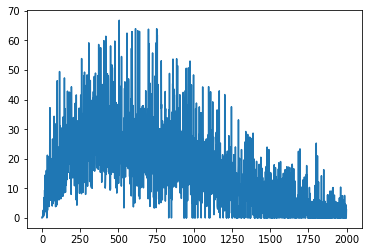

In [192]:
plt.plot(list_omega)
plt.show()

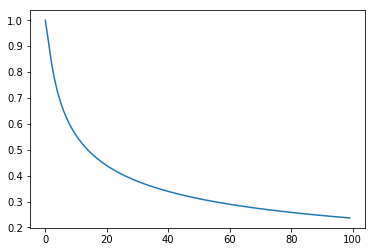

In [150]:
CB_evol=[np.sqrt( (1 + np.log(1+t))/(1+t) ) for t in range(100)]
plt.plot(CB_evol)
plt.show()